### Going Deeper(CV)_DJ2
# 8. GO/STOP! - Object Detection 시스템 만들기

> 평가문항
> - 1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.
- KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.
> - 2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.
- 바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.
> - 3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.
- 테스트 수행결과 90% 이상의 정확도를 보였다.

## 라이브러리 import

In [6]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

tf.config.list_physical_devices('GPU')

[]

In [7]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Shuffling kitti-train.tfrecord...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/423 [00:00<?, ? examples/s]

Shuffling kitti-validation.tfrecord...:   0%|          | 0/423 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/711 [00:00<?, ? examples/s]

Shuffling kitti-test.tfrecord...:   0%|          | 0/711 [00:00<?, ? examples/s]

Dataset kitti downloaded and prepared to /aiffel/tensorflow_datasets/kitti/3.2.0. Subsequent calls will reuse this data.


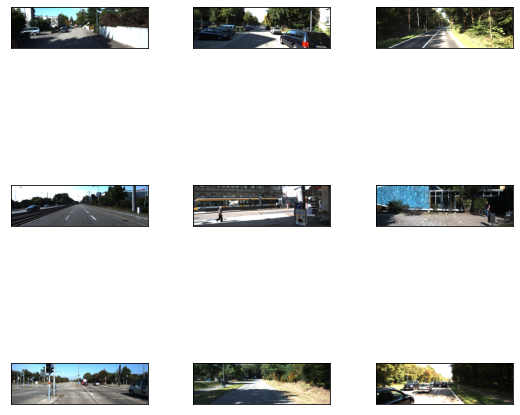

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

In [9]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'b

In [10]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.08, -0.98], dtype=float32)>, 'bbox': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.3584    , 0.06386474, 0.46818668, 0.14667472],
       [0.35402668, 0.00215781, 0.47152   , 0.09603059]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.42, 1.7 , 4.14],
       [1.52, 1.71, 4.11]], dtype=float32)>, 'location': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-19.31,   2.56,  29.23],
       [-21.94,   2.6 ,  29.  ]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 1])>, 'rotation_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.66, -1.62], dtype=float32)>, 'truncated': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>, 'type': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>}


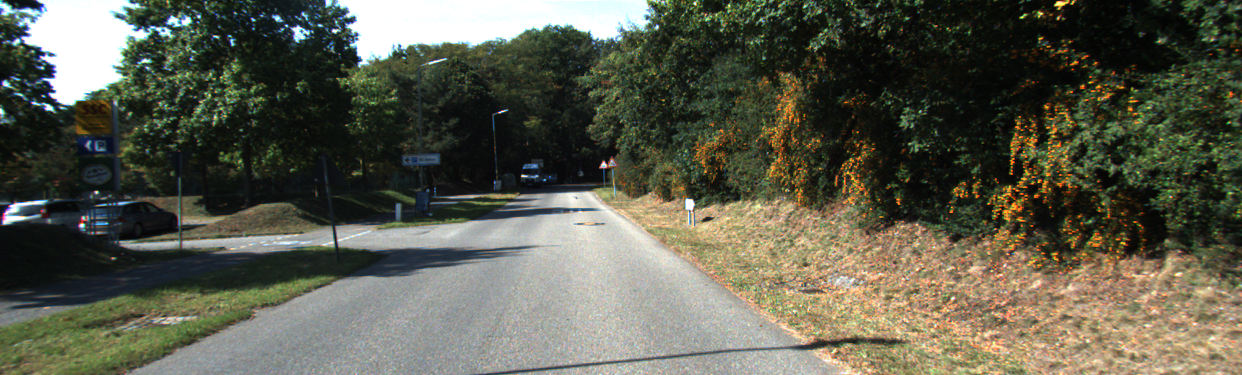

In [11]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

width : 1242, height : 375

이미지 내에 있는 bounding box : 2개
[[ 79.32001   240.6       182.17      199.43     ]
 [  2.6799998 242.23999   119.27      198.18     ]]
[ 79.32001 240.6     182.17    199.43   ]
[  2.6799998 242.23999   119.27      198.18     ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7FDBA1549F10>


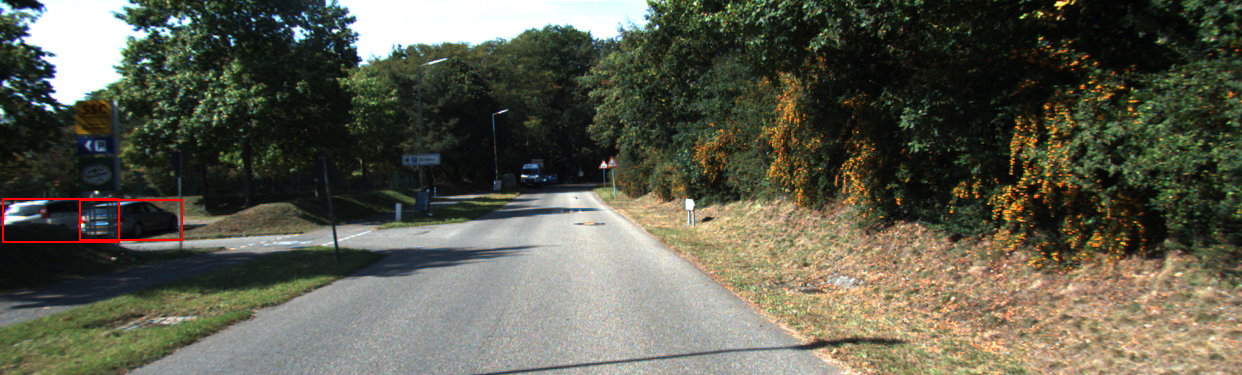

In [12]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

        # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print(f'width : {width}, height : {height}')
    print(f'\n이미지 내에 있는 bounding box : {object_bbox.shape[0]}개')
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

        # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [14]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [25:26<00:00,  4.16it/s]


In [15]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:58<00:00,  3.97it/s]


In [16]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


In [17]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 1 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-12-31 10:08:41.259867: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-12-31 10:08:41.259925: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-31 10:08:42.972045: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-31 10:08:42.998452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-31 10:08:42.999297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClo

In [20]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-12-31 11:23:22.922279: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-12-31 11:23:22.922341: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-31 11:23:24.586724: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-31 11:23:24.610082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-31 11:23:24.610941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClo

In [19]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)

NameError: name 'model' is not defined

In [13]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join(os.getenv("HOME"), 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


OSError: SavedModel file does not exist at: /aiffel/snapshots/resnet50_csv_50_infer.h5/{saved_model.pbtxt|saved_model.pb}

> **해결방법**
> - 1) 지정된 mpdel 폴더 안에 위치하는지 확인
> - 2) 패키지 설치 : ! sudo apt install python3-h5py
************************

#### 해결되지 않았다.....

- **batch_size, worker, epoch의 하이퍼 파라미터 값 설정의 오류인가??**
    - 1 epoch 당 학습 시간이 너무 오래 걸려서 **batch_size를 조정**하려고 했지만, 조금만 키워도 **에러가 발생**했다.
    - **workers 숫자도 4**에서 바꾸지 못했다.
    

***********************************

# 회고

- 데이터셋 가공은 진행되었다.
- RetinaNet 학습은 진행 되었지만, 케라스 모델로 변환을 할때 계속해서 오류가 났기 때문에 더 이상의 진행이 불가능했다.
- 해결 방법에 대해 찾아보기도 했지만, 해결하지 못해서 마지막까지 진행을 할 수 없었다.
- 방학이 끝난 후에 의견 공유를 많이 해봐야 할거 같다!!!